# FIN 514 - PS4 Q2 CRR
**Spring 2022**

This notebook provides the graphs for PS3 Q3 for the CRR model

## Packages and Configurations

The following common packages will be use on this notebook.

* numpy - [https://numpy.org/](https://numpy.org/)
* Pandas - [https://pandas.pydata.org/](https://pandas.pydata.org/)
* matplotlib - [https://matplotlib.org/](https://matplotlib.org/)
* Scipy Statistical functions - [https://docs.scipy.org/doc/scipy/reference/stats.html](https://docs.scipy.org/doc/scipy/reference/stats.html)


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
# ENTER INPUT FOR: start_step

start_step = 50

In [3]:
# ENTER INPUT FOR: N = num_steps

N = 1000

In [4]:
# ENTER INPUT FOR: S0 = Original Stock Price

S0 = 100.0

In [5]:
# ENTER INPUT FOR: K = Excercise Price of Call Option

K = 100

In [6]:
# ENTER INPUT FOR: B = Barrier level
B = 95

In [7]:
# ENTER INPUT FOR: sigma = Annualized (Future) Volatility of Stock Price Returns

sigma = 0.3

In [8]:
# ENTER INPUT FOR: r = Annualized Continously Compounded Risk-free Rate

r = 0.1

In [9]:
# ENTER INPUT FOR: T = Time Length of Option in which to Exercise (In Years)

T = 0.2

In [10]:
# ENTER INPUT FOR: q = Rate of continuous dividend paying asset 

q = 0

## Black-Sholes Model 

In [11]:
def black_scholes(S0, K, B, T, r, q, sigma):
    """
    Function to calculates the value of a European Down and Out Call Option using Black Scholes 
    
    S0: Original Stock Price
    K: Excercise Price of Call Option
    T: Time Length of Option in which to Exercise (In Years)
    r: Annualized Continously Compounded Risk-free Rate
    q: Rate of continuous dividend paying asset 
    sigma: Annualized (Future) Volatility of Stock Price Returns
    
    """
    
    cdf_mean = 0.0
    cdf_sd = 1.0
    
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    h1 = (np.log(B**2 / (K*S0)) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    h2 = (np.log(B**2 / (K*S0)) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    value = S0 * np.exp(-q * T) * st.norm.cdf(d1, cdf_mean, cdf_sd) 
    value = value - K * np.exp(-r * T) * st.norm.cdf(d2, cdf_mean, cdf_sd) 
    value = value - (B/S0)**(1+2*r/sigma**2)*S0*st.norm.cdf(h1,cdf_mean,cdf_sd)
    value = value + (B/S0)**(-1+2*r/sigma**2)*K*np.exp(-r * T)*st.norm.cdf(h2,cdf_mean,cdf_sd)     
 
    return value

## Binomial Model Function

In [12]:

def CRRB_model(S0, K, B, T, r, sigma, start_step, N):
    """
    Function to calculates the value of a European Put Option using the CRR Binomial Model 
    
    S0: Original Stock Price
    K: Excercise Price of Call Option
    T: Time Length of Option in which to Exercise (In Years)
    r: Annualized Continously Compounded Risk-free Rate
    sigma: Annualized (Future) Volatility of Stock Price Returns
    start_step: Starting time step
    N: Number of time steps
    
    """    
    
    # LIST TO SAVE RESULTS
    crrb_result = []
        
    # CREATE TWO DIMENSIONAL ARRAY OF SIZE [N+1,N+1] TO STORE ALL STEPS
    option_value = np.zeros([N+1, N+1])
    stock_value = np.zeros([N+1, N+1])    
    
    # FOR LOOP STATEMENT: For a Binomial Tree from start_step to N
    for n in range(start_step, N+1):
        delta = T / n
        u = np.exp(sigma * (delta)**0.5)
        d = 1 / u
        qu = (np.exp(r * delta) - d) / (u - d)
        qd = 1 - qu
        
    # CALCULATE OPTION VALUES AT CERTAIN STEPS AND POSITIONS WITHIN THE BINOMIAL TREE:
        j = n 

        for i in range(0, j):    
            stock_value[j, i] = S0 * (u**i) * (d**(j - i))
            option_value[j, i] = np.maximum(stock_value[j, i]-K, 0)

            if stock_value[j, i] < B:
                sd = stock_value[j, i]
                
        lamda = (sd*u*u - B)/(sd*u*u - sd)         
        for j in range(n-1, -1, -1):
            for i in range(j, -1, -1):
                pv = np.exp(-r * delta) * (qu * option_value[j + 1, i + 1] + qd * option_value[j + 1, i])
                option_value[j, i] = pv
                stock_value[j, i] = S0 * (u**i) * (d**(j - i))
                if stock_value[j, i] < B:
                        option_value[j, i] = 0

        
    # RELAY OUTPUTS TO DICTIONARY
        output = {'num_steps': n, 'CRR': option_value[0,0], 'lambda': lamda, 'sd': sd, 'su': sd*u*u}
        crrb_result.append(output)

    return crrb_result


In [13]:
crr = CRRB_model(S0, K, B, T, r, sigma, start_step, N)

In [14]:
bsc_value = black_scholes(S0, K, B, T, r, q, sigma)
bsc_value

4.397502559962934

In [15]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df = pd.DataFrame.from_dict(crr)

In [16]:
# CALCULATE THE ERROR FROM BINOMIAL MODEL COMPARED WITH BLACK-SHCOLES
df['error_CRR'] = df["CRR"] - bsc_value 

In [17]:
# INSPECT THE FIRST ROWS OF THE DATAFRAME
df.head()

,num_steps,CRR,lambda,sd,su,error_CRR
0,50,4.670343,0.356031,92.691384,96.276365,0.272840
1,51,4.659635,0.867329,94.519863,98.138864,0.262133
2,52,4.619167,0.382849,92.828095,96.347338,0.221665
3,53,4.608297,0.893429,94.621396,98.173992,0.210795
4,54,4.569699,0.409128,92.957325,96.414379,0.172197


In [18]:
# INSPECT THE LAST ROWS OF THE DATAFRAME
df.tail()

,num_steps,CRR,lambda,sd,su,error_CRR
946,996,4.594805,0.033006,94.222034,95.026554,0.197303
947,997,4.594239,0.536955,94.626062,95.433625,0.196736
948,998,4.592166,0.039084,94.227656,95.031414,0.194664
949,999,4.591599,0.543003,94.631297,95.438092,0.194097
950,1000,4.589532,0.045155,94.233262,95.036260,0.192029


In [19]:
# EXPORT THE DATA TO A CSV FILE
df.to_csv("Data/Q3crrb.csv", index=False)

### Binomial Model Error Rate

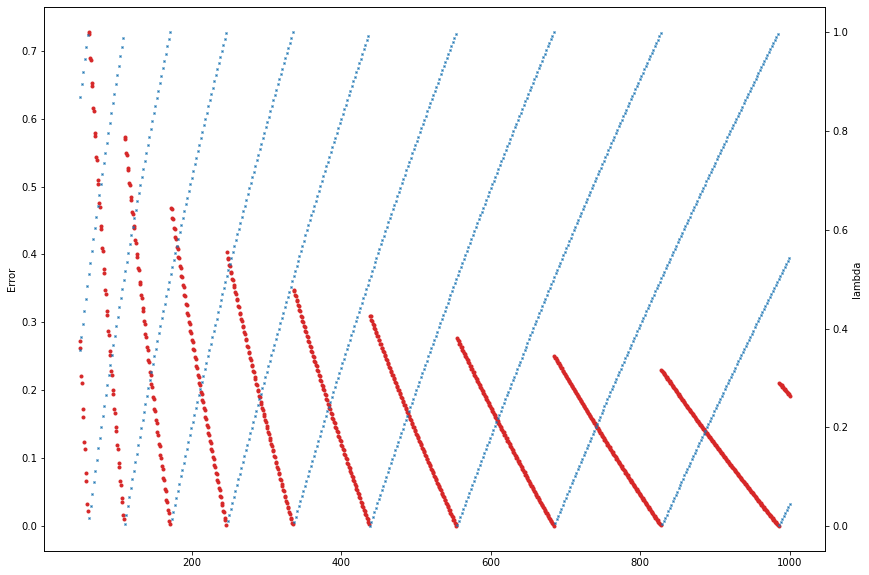

In [20]:
fig, ax1 = plt.subplots(figsize=(14,10))
ax1.set_ylabel('Error')
ax1.plot(df['num_steps'], df['error_CRR'], 'o', markersize=3, color = 'tab:red')
ax2 = ax1.twinx()
ax2.set_ylabel('lambda')
ax2.plot(df['num_steps'], df['lambda'], 'x', markersize=2, color = 'tab:blue')
plt.savefig('Images/Q3_crrb.png')
plt.show()